# Simulating elliptical objects (galaxies) in 2D and computing a simple correlation function of their shapes based on distance

#### The code is demonstrating that nearby objects with radial alignments are strongly correlated, while randomly oriented objects show no significant correlation

## 1. Simulating a galaxy catalog
N - number of objects needed to study correlations between their shapes

box_size - 2D box size, sets the physical space where objects are placed, to know how far apart the objects are.

(x,y) - random positions in the box, randomness insures unbiasness

theta - random elliptical orientation angle of each object (0 to π)

In [38]:
import numpy as np

N = 1000
box_size = 100.0
# Position
x = np.random.uniform(0, box_size, N)
y = np.random.uniform(0, box_size, N)
# Orientation angle
theta = np.random.uniform(0, np.pi, N)

## 2. Converting orientations to ellipticity components
e1 and e2 - components of the ellipticity using spin-2 representation

e1 = e * cos(2θ), e2 = e * sin(2θ)

In [39]:
e_min, e_max = 0.1, 0.4
def initiate_e(theta):
    e = np.random.uniform(e_min, e_max, N) # Ellipticity magnitude 
    e1 = e * np.cos(2 * theta)
    e2 = e * np.sin(2 * theta)
    return e1, e2

## 3. Computing pairwise galaxy separations
column_stack - creates a 2D array of (x,y) points

pdist - pairwise distance, computes the Euclidean distance between pairs, returns a distance list, memory efficiant but not very convenient for masking later

squareform - converts the distance list into a matrix

In [40]:
from scipy.spatial.distance import pdist, squareform

positions = np.column_stack([x, y])
distances = squareform(pdist(positions))

## 4. Measuring an alignment statistic
##### ξ​<small>++​</small>​(r)=⟨e​<small>1,i​</small>​e​<small>1,j​</small>​⟩<small>∣r<small>ij</small>​∈bin​</small>
-- two point correlation function (for all pairs of objects seprated by distance r, average the product of their shape components)

bins - 15 evenly spaced bin edges from 0 to 30 (so 14 bins), each bin representing a separation range. Allows us to estimate the correlation as a funciton of separation

mask - using NumPy broadcasting, compares specific bin edge to all distances, creates a boolean matrix

We're using two standard components of the two point shape correlation function: plus correlation, which measures how aligned the shapes are along the line connecting the two opjects, and cross correlation, measuring alignment rotated by 45 degrees relative to the said line (sensitive to twisting or tangential alignments)

In [41]:
bins = np.linspace(0,30,15)

def compute_xi(e1, e2, distances, bins):
    xi_plus = []
    xi_cross = []

    for i in range(len(bins)-1):
        mask = (distances > bins[i]) & (distances < bins[i+1])
        if np.sum(mask) == 0:
            xi_plus.append(0)
            xi_cross.append(0)
        else:
           xi_plus.append(np.mean((e1[:, None] * e1[None, :])[mask] + 
                                  (e2[:, None] * e2[None, :])[mask]))
           xi_cross.append(np.mean((e1[:, None] * e1[None, :])[mask] - 
                                  (e2[:, None] * e2[None, :])[mask]))
    return np.array(xi_plus), np.array(xi_cross)


## 5. Null Test
Initiate random orientations that act as a baseline

In [42]:
theta_rand = np.random.uniform(0, np.pi, N)

e1_rand, e2_rand = initiate_e(theta_rand)
xi_plus_rand, xi_cross_rand = compute_xi(e1_rand, e2_rand, distances, bins)

## 6. Injecting a known alignment and validating the correlation estimator

Forcing all objects to point radially outward from the centerm then measuring how strong that known alignment shows up in the correlation function, and comparing it to a random case

In [43]:
dx = x - box_size / 2
dy = y - box_size / 2

noise_sigma = 0.1
theta_radial = 0.5 * np.arctan2(dy, dx)
theta_noise = np.random.normal(0, noise_sigma, N)
theta = theta_radial + theta_noise

e1, e2 = initiate_e(theta)
xi_plus, xi_cross = compute_xi(e1, e2, distances, bins)

## 7. Bootstrap error estimation 
Provides realistic error bars for each separation bin

sample_idx - randomly picks N indices with replacements (some galaxies appear multiple times, some - not at all)

compute_xi() - computes the correlation for this resampled catalog

np.std(xi_boot, axis=0) - takes the standard deviation over bootstraps, returns error bars

In [44]:
n_boot = 50
xi_boot = []

for _ in range(n_boot):
    sample_idx = np.random.choice(N, N, replace = True)
    xi_b, _ = compute_xi(e1[sample_idx], e2[sample_idx], 
                         distances[np.ix_(sample_idx, sample_idx)], bins)
    xi_boot.append(xi_b)
xi_boot = np.array(xi_boot)
xi_err = np.std(xi_boot, axis = 0)

## 8. Plot the average correlation of object pairs
r_centers - creates representation radius of all bins, which is their center

Here, we are plotting the correlation between objects

Positive -> objects tend to align

Negative -> objects tend to be perpendicular

Zero -> random orientations

Plotting the null test: randomly assigned orientation, acts as a baseline

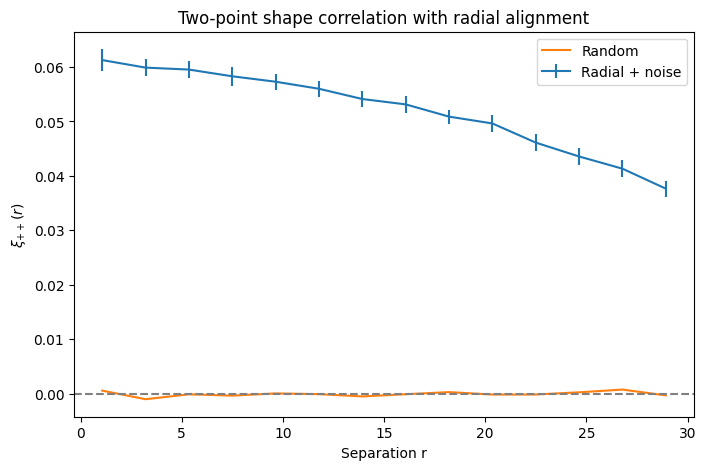

In [46]:
import matplotlib.pyplot as plt

r_centers = 0.5 * (bins[1:] + bins[:-1])

plt.figure(figsize=(8,5))
plt.errorbar(r_centers, xi_plus, yerr=xi_err, label='Radial + noise')
plt.plot(r_centers, xi_plus_rand, label='Random')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Separation r")
plt.ylabel(r"$\xi_{++}(r)$")
plt.title("Two-point shape correlation with radial alignment")
plt.legend()
plt.show()